# Project 2
## Group members
- Harmen de Beurs (S4134524)
- Agne Danilaite (S4273702)
- Andzej Gedzo (S4074580)
- Nicolò Montalti (S4947231)

## Assignment 1: Golf ball

## Assignment 2: Piezo-electro sensor
### Initial set up

In [11]:
# Clear all the variables from the previous assignment
%reset -f

In [28]:
import numpy as np                                      # used for array manipulation
from scipy.integrate import solve_ivp, odeint           # used to solve differential equation
from scipy.signal import find_peaks                     # used to analyze the result
from scipy import fft                                   # fourier transform
from matplotlib import pyplot as plt, cm                # plotting
from ipywidgets import widgets                          # interactive widgets
import sympy as sym                                     # symbolic computation
from sympy.physics import mechanics
from sympy.utilities.lambdify import lambdify

# display plots in the notebook
# FOR COLAB
%matplotlib inline            
# FOR JUPYTER NOTEBOOK
#%matplotlib widget              

### Derivation of the differential equation

In [29]:
# Symbolic variables

# x: displacement [m]
# q: charge [C]
# xd, xdd, qd, qdd: time dderivatives of the previous variables
# k: spring coefficient [N/m]
# K: constant of q = K*x [C/m]
# m: mass
# omega_0: natural angolar frequency (sqrt(k/m))
# alpha: non-linear coefficient [1/N^2]
# lmbd: damping factor [Ns/m]
# xi: adimensional damping factor (lmbd/2sqrt(km)) [1]
# d: K/k [C/N]
# F: force [N]
# t: time [s]

x, q = mechanics.dynamicsymbols('x, q')
xd, qd = mechanics.dynamicsymbols('x, q', 1)
xdd, qdd = mechanics.dynamicsymbols('x, q', 2)
k, K, omega_0, alpha, xi, lmbd, m, d, F, t = sym.symbols('k, K, omega_0, alpha, xi, lambda, m, d, F, t')  

We know that the ideal spring euqation $F = kx$ can be improved adding a non-linear component $\alpha kx^3$. So for the static case, without friction we have

In [14]:
F_el = k*x + alpha * k**3 * x**3
F_el

alpha*k**3*x(t)**3 + k*x(t)

Adding friction, proportional to $\dot{x}$ with a coefficient $\lambda$, and inertia we have


In [15]:
F_vis = lmbd * xd
F_in = m*xdd
expr = F_el + F_vis + F_in
expr

alpha*k**3*x(t)**3 + k*x(t) + lambda*Derivative(x(t), t) + m*Derivative(x(t), (t, 2))

Since $q = Kx$

In [16]:
expr = expr.subs(x, q / K).doit()
expr

k*q(t)/K + lambda*Derivative(q(t), t)/K + m*Derivative(q(t), (t, 2))/K + alpha*k**3*q(t)**3/K**3

Using $\omega_0 = \sqrt{k/m}$, $\xi = \lambda/2\sqrt{km}$ and $d = K / k $ we get


In [17]:
expr = (m / K) * (expr * K / m).simplify()
expr = expr.subs(K, d*k)
expr = expr.subs(k/m, omega_0**2)
expr = expr.subs(lmbd/m, 2*omega_0*xi)
expr = expr.subs(m/k, 1/omega_0**2)
expr = expr.collect(omega_0**2)
expr

(omega_0**2*(alpha*q(t)**3/d**2 + q(t)) + 2*omega_0*xi*Derivative(q(t), t) + Derivative(q(t), (t, 2)))/(d*omega_0**2)

which, in the linear case ($\alpha = 0$), reads

In [18]:
expr.subs(alpha, 0)

(omega_0**2*q(t) + 2*omega_0*xi*Derivative(q(t), t) + Derivative(q(t), (t, 2)))/(d*omega_0**2)

We know convert the symbolic expression to a function that computes $\ddot{q}$ given the force $F$ and the parameters

In [19]:
expr_qdd = sym.solvers.solve(expr - F, qdd)[0]
display(expr_qdd)

qdd_function = lambdify([q, qd, omega_0, xi, d, alpha, F], expr_qdd)

omega_0*(-alpha*omega_0*q(t)**3 + d**2*(F*d*omega_0 - omega_0*q(t) - 2*xi*Derivative(q(t), t)))/d**2

### Solution of the differential equation
We can know define the functions necessary to solve the differential equation

In [20]:
def force(t, omega):
    '''
    This function computes the force with which the piezo-electro sensor is stimulated.
    It is a harmonic force of amplitude 1 and angular frequency omega.

    Parameters:
    -----------
    t: time [s]
    omega: angular frequency [s^-1]

    Returns:
    --------
    (float) sin(omega*t)
    '''
    return np.sin(omega*t)

def q_vector_derivative(t, q_vector, omega, omega_0, xi, d, alpha):
    '''
    This function 

    Parameters:
    -----------
    t: time [s]
    q_vector: numpy array of the form (q,q'), where q is the charge [C]
    omega: angular frequency of force [s^-1]
    omega_0: natural frequency of the system [s^-1]
    xi: damping factor of the system [dimensionless]
    d: charge sensitivity parameter [C/N]

    Returns:
    --------
    (numpy array) derivative of [q,q']
    '''

    q0 = q_vector[0]                                                                                                            # q(t)
    q1 = q_vector[1]                                                                                                            # q'(t)
    q0_d = q1                                                                                                                   # q(t+dt)' = q'(t)
    q1_d = d * omega_0**2 * force(t, omega) - 2 * xi * omega_0 * q1 - omega_0**2 * (1 + alpha * q0**2 / d**2) * q0              # q(t+dt)'' according to the differential equation

    return np.array([q0_d, q1_d])

def solve_differential_equation(periods, initial_condition, omega, omega_0=1, xi=1, d=1, alpha=0):
    '''
    Solve the differential equation q_vector(t)' = q_vector_derivative(t, omega, omega_0, xi, d, alpha)
    
    Parameters:
    ------------
    time_points: array-like sequence of time instants where to solve the equation
    inital_condition: array with the inistal condition [q_init, q_init']
    omega: angular frequency of force [s^-1]
    omega_0: natural frequency of the system [s^-1]
    xi: damping factor of the system [dimensionless]
    d: charge sensitivity parameter [C/N]
    alpha: non-linear factor [N^-2]

    Returns:
    --------
    (time_points, q_vector_solution)
    '''

    if omega == 0:
        total_time = periods * 2 * np.pi / omega_0
    else:
        total_time = periods * 2 * np.pi / omega                                                                                 # time where to compute the solution
    time_points = np.linspace(0, total_time, 100*periods)                                                                       # time is split in 100 points per period

    jacobian = lambda t, q_vect, omega=omega, omega_0=omega_0, alpha=alpha, d=d, xi=xi :  np.array([[0, 1],
                                                                                                   [omega_0**2 + 3 * alpha * q_vect[0]**2 / d**2, -2*xi*omega_0]])

    ode_solution = solve_ivp(q_vector_derivative, (0, total_time),
                             initial_condition, t_eval=time_points,
                             args=(omega, omega_0, xi, d, alpha),
                             method='RK45')#, jac=jacobian)                                                                       # LSODA method from odeint  
                            
    return (ode_solution.t / total_time * periods, ode_solution.y, ode_solution.t)

### Validation
If we set $\xi =\alpha = \omega = 0$ and $d = 1$, since $\sin(0) = 0$, the differential equation becomes
$$
\ddot{q}+\omega_0^2 q = 0
$$
which is the equation of a harmonic oscillator. We know that for the initial conditions ($q=1, \dot{q}=0$) the solution is $\cos(\omega_0 t)$. The velocity should be out of phase by $\pi/2\omega_0$.

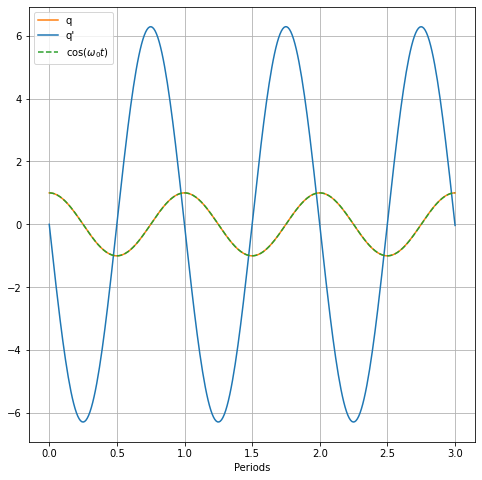

In [21]:
def plot_validation():
    '''
    This function plots q, q' and cos(omega_0*t) with omega = xi = alpha = 0, d = 1 and initial condition [1,0].
    '''
    omega_0 = 2*np.pi
    per, y, t = solve_differential_equation(3, np.array([1, 0]), omega=0, omega_0=omega_0, xi=0, d=1, alpha=0)

    fig = plt.figure(figsize=(8,8))
    ax = fig.add_subplot()
    ax.plot(per,y[0], label='q', color='tab:orange')
    ax.plot(per, y[1], label='q\'', color='tab:blue')
    ax.plot(per, np.cos(omega_0*t), linestyle='--', label=r'$\cos(\omega_0 t)$', color='tab:green')
    ax.legend()
    ax.grid()
    ax.set_xlabel('Periods')

plot_validation()

The plot is in agreement with our expextations.

Adding the damping factor, we expect the oscillator to be underdamped for $\xi < 1$, critically damped for $\xi = 1$ and overdamped for $\xi > 1$. For $\xi >> 1$ we expect $q$ not to change. The underdamped solution should decrease as $e^{-\xi \omega_0 t}$.

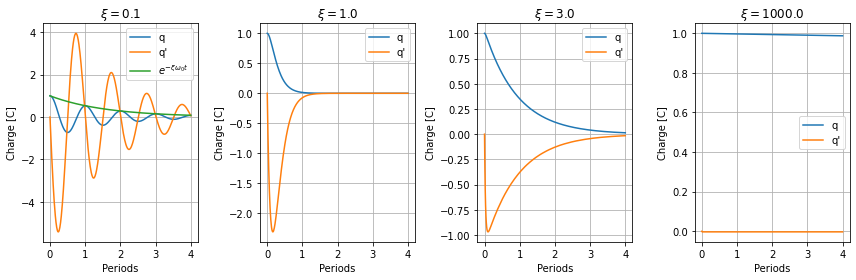

In [22]:
def plot_validation_damping():
    '''
    This function generates three plots of q over t. The first one with xi = 0.1 (underdamped), the second with xi = 1 (critically damped) and the third one with xi = 3 (overdamped).
    '''
    xis = np.array([0.1, 1, 3, 1000])
    omega_0 = 2*np.pi
    fig = plt.figure(figsize=(12,4))
    axs = fig.subplots(1,xis.size)

    for xi, ax in zip(xis, axs):
        per, y, t = solve_differential_equation(4, np.array([1, 0]), omega=0, omega_0=omega_0, xi=xi, d=1, alpha=0)
        ax.plot(per, y[0], label='q')
        ax.plot(per, y[1], label='q\'')
        if ax == axs[0]:
            ax.plot(per, np.exp(-0.1*omega_0*t), label=r'$e^{-\xi \omega_0 t}$')

        ax.grid()
        ax.set_xlabel('Periods')
        ax.set_ylabel('Charge [C]')
        ax.set_title(r'$\xi = ${}'.format(xi))
        ax.legend()
    

    fig.tight_layout()

plot_validation_damping()

Also theese plots agree with our expectations.

### Analysis: linear case
We first investigate the linear case ($\alpha = 0$). In particular we are interested in the dependence of the solution on $\omega$ and $\xi$

In [24]:
def plot_time_dependence(omega, xi, periods):
    '''
    Makes three plots given the values of omega and xi:
        - the first plot shows the dependance of charge on time over the selected amount of periods;
        - the second one is a phase diagram;
        - the third one shows the fourier transform of the first plot, as well as omega and omega_0.    
    '''
    initial_condition = np.array([0,0])
    omega_0 = 1

    period, y, t = solve_differential_equation(periods, initial_condition, omega=omega, omega_0 = omega_0, xi=xi)
    
    fig = plt.figure(figsize=(16,4))
    axs = fig.subplots(1,3)
    axs[0].set_xlabel('Time [s]')
    axs[0].set_ylabel('Charge [C]')
    axs[0].plot(t, y[0])
    axs[0].grid(True)
    axs[0].set_title('Time evolutionover {} periods'.format(periods))

    axs[1].plot(y[0], y[1])
    axs[1].grid(True)
    axs[1].set_title('Phase space')
    axs[1].set_xlabel(r'$q$ [C]')
    axs[1].set_ylabel(r'$\dot{q}$ [C/s]')

    N = t.size
    delta_t = t[1]-t[0]
    signal_fft = fft.fft(y[0])                                                                # Fourier transform off q(t)
    frequencies = fft.fftfreq(N, delta_t)                                                     # discrete set of frequencies where the FFT is computed

    axs[2].set_xlim(0, 2*np.pi)
    axs[2].plot(frequencies[:N//2]*2*np.pi, np.abs(signal_fft[: N//2]), label='FFT (charge)') # plot the absolute value of the FFT, only for omega > 0
    axs[2].axvline(omega_0, color='tab:red', label=r'$\omega_0$ (charge)')                    # display the value of omega_0
    axs[2].axvline(omega, color='tab:orange', label=r'$\omega$ (force)')                      # display the value of omega
    axs[2].grid(True)
    axs[2].set_title('Fourier transform')
    axs[2].set_xlabel(r'$\omega$ [$s^{-1}$]')
    axs[2].set_ylabel('Amplitude (a.u.)')
    axs[2].legend()

    fig.tight_layout()
    

# With the following widgets it's possible to interact with the plots modifying the values of omega, xi and the number of periods.

widget_omega = widgets.FloatSlider(np.pi, min=0.01, max=np.pi*2, description='Omega')
widget_xi = widgets.FloatSlider(1, min=0, max=2, description='Xi')
widget_periods = widgets.IntSlider(10, min=1, max=100, description='Periods')

widgets.interact(plot_time_dependence, omega = widget_omega, xi=widget_xi, periods=widget_periods)

interactive(children=(FloatSlider(value=3.141592653589793, description='Omega', max=6.283185307179586, min=0.0…

<function __main__.plot_time_dependence>

Varying $\omega$ and $\xi$ in the prevoius plots, we found out that: by keeping $\xi$=1 and putting $\omega$=0.01 and making $\omega$ gradually larger we see both the initial and the final amplitude will become smaller, the time it takes for the amplitude to stabilize doesn't seem to depend on the value of $\omega$ and is about 10 seconds.

If we keep $\omega$=3.14 and vary $\xi$ it will take less time for te amplitude to stabilize as $\xi$ gets bigger also the final amplitude will decrease as $\xi$ gets bigger, we see the same result for different values of $\omega$.

From the second plot we see that if $\omega$ increases it takes more periodes to stabilize and if $\xi$ increases the periodes needed to stabilize become smoother but there isn't a clear dependence between $\xi$ and the amount of periodes needed to stabilize.

#### Dependence of the stable solution amplitude on $\omega$ and $\xi$

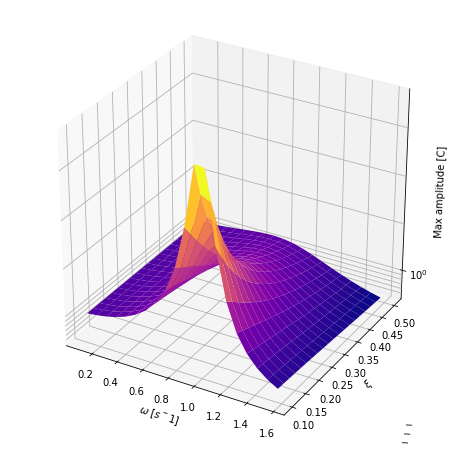

In [25]:
def plot_xi_omega_dependance():
    '''
    Plots the amplitude after 20 periods (stable solution) for different values of xi and omega.
    '''
    N = 20                                                                                      # Number of division of omega and xi range. If N > 30, computation takes too much time: O(N^2)
    omegas = np.linspace(0.1, np.pi/2, N)
    xis = np.linspace(0.1, 0.5, N)

    def solve_for_omega_xi(omega, xi):
        periods = 20
        _, y, _ = solve_differential_equation(periods, np.array([0,0]), omega=omega, xi=xi)
        peaks, _ = find_peaks(y[0])
        return y[0, peaks[-1]]                                                                  # return the last peak (amplitude of the stable solution)

    omegas, xis = np.meshgrid(omegas, xis)                                                      # mixing omegas and xis on all the xy plane
    vect_func = np.vectorize(solve_for_omega_xi)                                                # preparing the function to be computed
    amplitude = vect_func(omegas, xis)                                                          # computing the function all over the plane

    fig = plt.figure(figsize=(8,8))
    ax = fig.add_subplot(projection='3d')
    ax.plot_surface(omegas, xis, amplitude, cmap=cm.plasma)
    ax.set_zscale('log')                                                                        # setting a log scale on the z axis to improve plot clarity
    ax.set_xlabel(r'$\omega$ [$s^-1$]')
    ax.set_ylabel(r'$\xi$')
    ax.set_zlabel('Max amplitude [C]')

plot_xi_omega_dependance()

For the assignment $\omega_0$ was assumed to be $\omega_0=1$. From the plot it can be seen that the maximum amplitude of charge is when $\omega = \omega_0=1$. Matching $\omega$ and $\omega_0$ frequencies create a resonance resulting in the highest amplitude of charge. However, that is only applicable for small values of $\xi$. In fact, the amplitude of charge decreases exponentially as $\xi$ increases.

### Analysis: non-linear case

In [30]:
def plot_time_dependence(omega, periods, linearity='Linear'):
    '''
    Makes three plots given the valuee of omega over the chosen amount of periods:
        - the first plot shows the dependance of charge on time over the selected amount of periods;
        - the second one is a phase diagram;
        - the third one shows the fourier transform of the first plot, as well as omega and omega_0. 

    If linearity = 'Linear', the function returns the linear solution. If it is 'Non-linear', the function return the non-linear solution.
    '''
    if linearity == 'Non-linear':
        alpha = 0.1
    else:
        alpha = 0
        
    xi = 0.01
    omega_0 = 1

    initial_condition = np.array([0,0])
    period, y, t = solve_differential_equation(periods, initial_condition, omega=omega, omega_0=omega_0, xi=xi, alpha=alpha)
    
    fig = plt.figure(figsize=(16,4))
    axs = fig.subplots(1,3)
    axs[0].set_xlabel('Periods')
    axs[0].set_ylabel('Charge [C]')
    axs[0].plot(period, y[0])
    axs[0].grid(True)
    axs[0].set_title('Time evolution over {} periods'.format(periods))

    axs[1].plot(y[0], y[1])
    axs[1].grid(True)
    axs[1].set_title('Phase space')
    axs[1].set_xlabel(r'$q$ [C]')
    axs[1].set_ylabel(r'$\dot{q}$ [C/s]')

    N = t.size
    delta_t = t[1]-t[0]
    signal_fft = fft.fft(y[0])                                                                # Fourier transform off q(t)
    frequencies = fft.fftfreq(N, delta_t)                                                     # discrete set of frequencies where the FFT is computed

    axs[2].set_xlim(0, 2*np.pi)
    axs[2].plot(frequencies[:N//2]*2*np.pi, np.abs(signal_fft[: N//2]), label='FFT (charge)') # plot the absolute value of the FFT, only for omega > 0
    axs[2].axvline(omega_0, color='tab:red', label=r'$\omega_0$ (charge)')                    # display the value of omega_0
    axs[2].axvline(omega, color='tab:orange', label=r'$\omega$ (force)')                      # display the value of omega
    axs[2].grid(True)
    axs[2].set_title('Fourier transform')
    axs[2].set_xlabel(r'$\omega$ [$s^{-1}$]')
    axs[2].set_ylabel('Amplitude (a.u., log scale)')
    axs[2].set_yscale('log')
    axs[2].legend()

    fig.tight_layout()
    

# With the following widgets it's possible to interact with the plots modifying the values of omega, the number of periods. It is also possible to add non-linearity effects
widget_omega = widgets.FloatSlider(2, min=0.01, max=3, description='Omega')
widget_periods = widgets.IntSlider(50, min=1, max=300, description='Periods')
widget_linearity = widgets.RadioButtons(options=['Linear', 'Non-linear'], description='Linearity')


widgets.interact(plot_time_dependence, omega = widget_omega, periods=widget_periods, linearity = widget_linearity)

interactive(children=(FloatSlider(value=2.0, description='Omega', max=3.0, min=0.01), IntSlider(value=50, desc…

<function __main__.plot_time_dependence>

We can now analyse the difference between the lienar and non-linear case. Let's first analyse the time needed by the system to stabilize. From now on, we assume $\xi = 0.01$ and $\alpha=0.1$
For small values of $\omega$ ($\approx 0.1$), the oscillations stabilize immediately at an amplitude of $\approx 1$, both in the linear and non-linear case. On the other hand, for large values of $\omega$ ($\approx 3$), the system nees more than 150 periods to stabilize (at an amplitude of $\approx 0.1$), with no significant differences between the linear and non-linear case.

The most interesting values of $\omega$ are in proximity of $\omega_0 = 1$. Here the linear solution needs more than 80 periods to stabilize, and the amplitude increase from a small amplitude  to more than 40 in this time. On the other hand, the non-linear system is much more stable. It starts with an amplitude of 3 and it stabilizes at 2 in 40/60 periods.
The same analysis can be done looking at the phase diagram, where the linear solution evolves as a spyral going from the center to the outside, whereas the non-linear solution converges to a smaller circle.

Looking at the fourier transform plot ($\omega = 0.4$), it is interesting to notice that the linear case has only two relevant frequencies ($\omega$ and $\omega_0$). On the contrary, the signal of the non-linear solution is more complex, since it has also frequencies different from $\omega$ and $\omega_0$, with no appereant order.

#### $\omega$ dependence
We can know analyze the dependence on $\omega$ in  more depth. Below we have a plot of the amplitude for the stable solution for different values of $\omega$, both for linear and non-linear case.

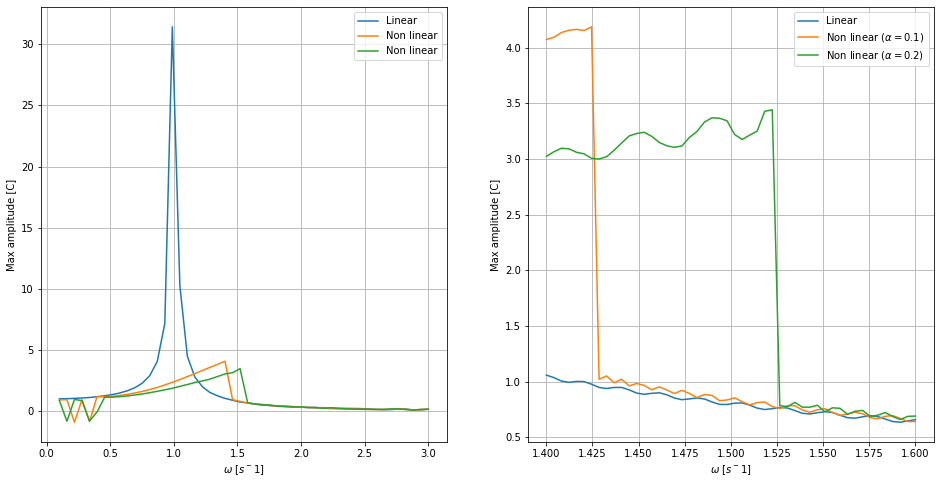

In [ ]:
def plot_omega_dependance():
    '''
    Plots the amplitude after 100 periods (stable solution) for different values of xi and omega.
    The function solves the differential equation 300 times, so it will take ~45s
    '''
    N = 50                                                                                              
    omegas_big = np.linspace(0.1, 3, N)
    omegas_small = np.linspace(1.4, 1.6, N)
    xi = 0.01
    alpha = 0.1
    alpha2 = 0.2 

    def solve_for_omega(omega, alpha):
        periods = 100
        _, y, _ = solve_differential_equation(periods, np.array([0,0]), omega=omega, xi=xi, alpha=alpha)
        peaks, _ = find_peaks(y[0])
        return y[0, peaks[-1]]                                                                          
    vect_func = np.vectorize(solve_for_omega)
    
    amplitude_linear_small = vect_func(omegas_small, 0)                                                     
    amplitude_non_linear_small = vect_func(omegas_small, alpha)    
    amplitude_linear_big = vect_func(omegas_big, 0)                                                     
    amplitude_non_linear_big = vect_func(omegas_big, alpha)  
    amplitude_non_linear_big_2 = vect_func(omegas_big, alpha2)  
    amplitude_non_linear_small_2 = vect_func(omegas_small, alpha2)                                                               

    fig = plt.figure(figsize=(16,8))
    axs = fig.subplots(1, 2)

    axs[0].plot(omegas_big, amplitude_linear_big, label='Linear')
    axs[0].plot(omegas_big, amplitude_non_linear_big, label='Non-linear')
    axs[0].plot(omegas_big, amplitude_non_linear_big_2, label='Non-linear')
    axs[0].set_xlabel(r'$\omega$ [$s^-1$]')
    axs[0].set_ylabel('Max amplitude [C]')
    axs[0].grid(True)
    axs[0].legend()
    
    axs[1].plot(omegas_small, amplitude_linear_small, label='Linear')
    axs[1].plot(omegas_small, amplitude_non_linear_small, label=r'Non-linear ($\alpha=0.1$)')
    axs[1].plot(omegas_small, amplitude_non_linear_small_2, label=r'Non-linear ($\alpha=0.2$)')
    axs[1].set_xlabel(r'$\omega$ [$s^-1$]')
    axs[1].set_ylabel('Max amplitude [C]')
    axs[1].grid(True)
    axs[1].legend()

plot_omega_dependance()

We can immediately see that the linear solution has a strong dependence on $\omega$. It is clear that it has a resonant behaviour for $\omega \approx \omega_0$. The non-linear solution, on the opposite, stabilizes at an amplitude between 0 and 5 for every value of $\omega$. There is however some resonance at $1.25 < \omega < 1.75$ that we can further investigate in the second plot. We can see that there is a steep drop around 1.425. We can attribute this drop to non-linear effects. If we change $\alpha$ to 0.2, the drop moves around 1.525. This confirms that the drop is to attributed to the non-linear term, governed by $\alpha$.